In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

from sklearn import linear_model
from random import shuffle
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

import wikipedia
import warnings
import random

from bs4 import BeautifulSoup
import requests
import re
from fuzzywuzzy import fuzz
from sklearn.svm import SVR

D:\Program Files\anaconda\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# 0 Utility

In [2]:
def correlation(df):
    '''Draw the correlation heat map
        
    Args:
        df (DataFrame): the data
    '''
    sns.set(style="white")
    corr = df.corr()
    
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.tril_indices_from(mask)] = False
    
    # Set up the matplotlib figure
    plt.subplots(figsize=(22, 22))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(255, 10, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, annot=True, annot_kws={"size":15}, linewidth=3, cbar_kws={"shrink": 0.6})

In [3]:
def z_score_norm(df, feature_list):
    """ Do the z-score method on selected features in feature_list. 
        z = (x - mean)/std

    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())
        
        
        
def do_log(df, feature_list):
    '''Do logarithm on selected features in feature_list.
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    '''
    
    for col in feature_list:
        df[col] = np.log(df[col])
        
        
        
def powerlaw_rank(df_music):
    ''' Do powerlaw on the original rank.
        y = 100*rank^(-0.66)
        However, I find that differnent coefficient and exponent do not affect MAE. Don't know why.
    
    Args:
        df_music (pandas.DataFrame): dataset
    '''
    
    df_music.insert(1, 'RankPowerlaw', df_music.Rank)  # insert right next to column 'Rank'
    df_music['RankPowerlaw'] = df_music['RankPowerlaw'].astype('float')
    for i in range(0, len(df_music)):
        df_music.iat[i,1] = 100 * math.pow(df_music.iat[i,1], -0.66)

In [4]:
def performance_statistics(model_name, target, pred):
    '''Plot a table of performance statistics
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    mae   = mean_absolute_error(target, pred)
    medae = median_absolute_error(target, pred)
    r2    = r2_score(target, pred)
    
    columns = ['Model', 'Mean Absolute Error', 'Median Absolute Error', 'R2 Score']
    cell_text = [['%s' % model_name, '%1.3f' % mae, '%1.3f' % medae, '%1.3f' % r2]]
    
    nrow = 1
    ncol = len(columns)
    
    fig = plt.figure(figsize=(ncol*2, nrow*0.2))
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    table = ax.table(cellText=cell_text, colLabels=columns, loc='center')
    table.set_fontsize(14)
    table.scale(1.5, 1.5)
    
    
    
def error_distribution(model_name, target, pred):
    '''Plot a histogram of the error distribution
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    err = pred - target   # error is a Series
    min_err = err.min()
    max_err = err.max()
    fig = plt.figure()
    ax = err.plot.hist(bins=20, figsize=(7,7), edgecolor='black')
    ax.set_xticks(np.arange(math.floor(min_err), math.ceil(max_err)))
    ax.set_title('%s - Error Distribution' % model_name, fontsize=18)
    ax.set_xlabel('Error', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.grid()
    
    fig.savefig('../figure/%s_error_dist.png' % model_name)
    
    

def prediction_error_map(model_name, target, pred):
    '''Plot the prediction error map (similar to confusion matrices in classification problems)
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    y_min = target.min()*0.98
    y_max = target.max()*1.01
    fig, ax = plt.subplots(figsize=(7,7))
    #plt.scatter(target, pred, edgecolor='black', s=15)
    plt.scatter(target, pred, s=13)
    ax.plot([y_min, y_max], [y_min, y_max], 'k--', lw=2)
    ax.set_xticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_yticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_title('%s - Prediction Error Map' % model_name, fontsize=18)
    #ax.set_xlabel('Real Spotify (log) Play Count', fontsize=14)
    ax.set_xlabel('Target', fontsize=14)
    ax.set_ylabel('Prediction', fontsize=14)
    #ax.axis([y_min,y_max,y_min,y_max])
    ax.grid()
    
    fig.savefig('../figure/%s_error_map.png' % model_name)
    
    
    
def permutation_test(model,target,pred):
    '''do permuation tests
    
    Args:
        model_name: model
        target (Series):  target data
        pred   (ndarray): predition results
    ''' 
    pred = cross_val_predict(model, X=feature, y=target, cv=10)
    mae  = mean_absolute_error(target,pred)
    mae_list=[mae]
    count=0
    while count<100:
        count = count+1 
        target_to_list = target.tolist()
        shuffle(target_to_list)
        target_per = pd.DataFrame({'playcount':target_to_list})
        pred1 = cross_val_predict(model, X=feature, y=target_per, cv=10)
        mae_shuffle = mean_absolute_error(target,pred1)
        mae_list.append(mae_shuffle)
    num_bins = 20
    fig, ax = plt.subplots(figsize=(7,7))
    n, bins, patches = ax.hist(mae_list, num_bins)
    ax.set_title('Permutation test')
    ax.set_xlabel('$Log(playcount)-mae$', fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.get_children()[0].set_color('r')
    ax.grid()
    
    
    
def evaluation(model, feature, target):
    """ Run the model on X and y using cross validation. Then output:
        1) performance statistics
        2) error distributions
        3) prediction error map
        
    Args:
        model   (object):    the machine learning object to fit the data
        feature (DataFrame): feature data
        target  (Series):    target  data
        
    This is version 0.11.10 (Nov. 10th)
    
    Todo:
        parameter "model" should be a list of models in the future
    """
    
    model_name = str(model)        # 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)'
    end = model_name.find('(')
    model_name = model_name[0:end] # 'LinearRegression'
    
    '''Do the prediction by cross validation'''
    pred = cross_val_predict(model, X=feature, y=target, cv=10)  # default is 10-fold
    
    print('This is the plots/reports of %s'  % model_name)
        
    error_distribution(model_name, target, pred)
    
    prediction_error_map(model_name, target, pred)
    
    #permutation_test(model, target, pred)
    
    performance_statistics(model_name, target, pred)    

# 1 Final

In [47]:
df_music5 = pd.read_csv('../music_data/dataset-12-6.csv')

In [48]:
df_music5.SpotifyPlayCount = np.log(df_music5.SpotifyPlayCount)

In [49]:
df_music5 = df_music5.loc[:, ['SpotifyPlayCount', 'Grammy', 'beat', 'country', 'easyListening', 'folkORfunk', 'instrumental', 'jazz', 'pop', 
                          'popRock', 'r&b', 'rock', 'rockabilly', 'sunshinePop', 'traditionalPop']]

In [50]:
df_music5

,SpotifyPlayCount,Grammy,beat,country,easyListening,folkORfunk,instrumental,jazz,pop,popRock,r&b,rock,rockabilly,sunshinePop,traditionalPop
0,15.425179,2,0,0,1,0,0,0,0,0,0,0,0,0,0
1,15.291952,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,15.246003,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,13.455567,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,13.597689,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,13.138430,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,14.600468,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,14.918937,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,14.183606,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9,12.358455,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [8]:
do_log(df_music5,feature_list=['RankPowerlaw', 'SpotifyPlayCount', 'WikiWordCount', 'Followers'])
z_score_norm(df_music5, feature_list=['RankPowerlaw', 'Year', 'WikiWordCount', 'Followers', 'Popularity'])

In [9]:
df_music5.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,Grammy,...,folkORfunk,instrumental,jazz,pop,popRock,r&b,rock,rockabilly,sunshinePop,traditionalPop
0,1,3.935457,Percy Faith,"Theme From ""A Summer Place""",-1.569234,15.425179,-0.483013,-0.330945,0.062475,2,...,0,0,0,0,0,0,0,0,0,0
1,2,3.185383,Jim Reeves,He'll Have To Go,-1.569234,15.291952,0.735416,0.361105,0.430713,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2.746618,The Everly Brothers,Cathy's Clown,-1.569234,15.246003,0.706678,0.631824,0.641134,0,...,0,0,0,1,0,0,0,0,0,0
3,30,0.254925,The Everly Brothers,Let It Be Me,-1.569234,13.455567,0.706678,0.631824,0.641134,0,...,0,0,0,1,0,0,0,0,0,0
4,70,-0.661961,The Everly Brothers,So Sad,-1.569234,13.597689,0.706678,0.631824,0.641134,0,...,0,0,0,1,0,0,0,0,0,0


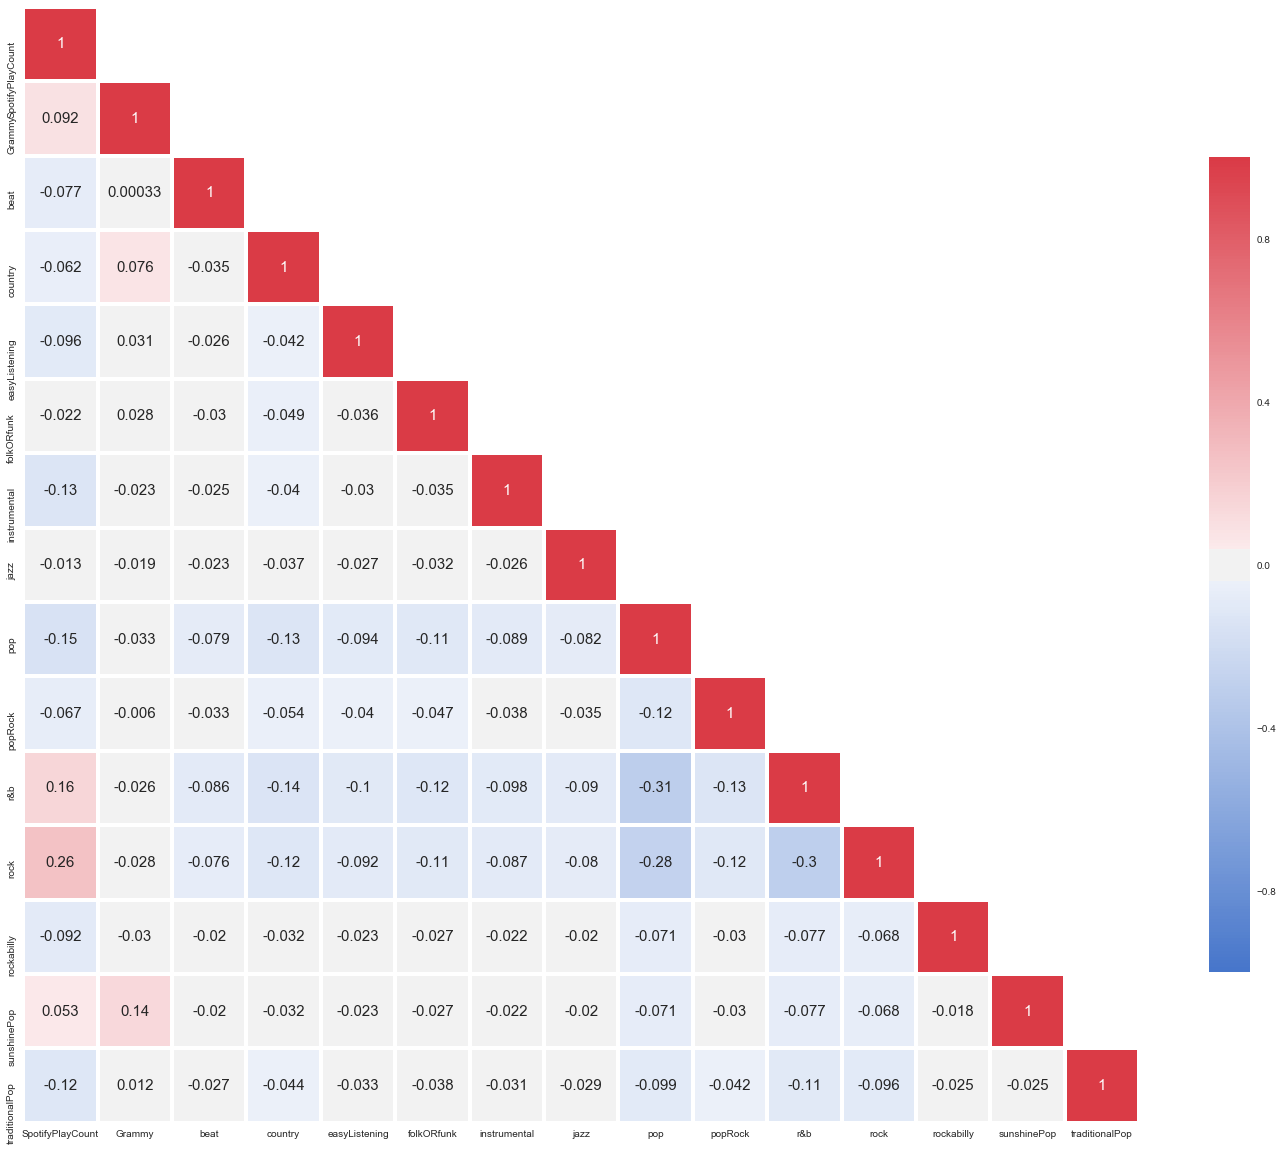

In [51]:
sns.set(style="white")
corr = df_music5.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.tril_indices_from(mask)] = False

# Set up the matplotlib figure
plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(255, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True, annot_kws={"size":15}, linewidth=3, cbar_kws={"shrink": 0.6})

In [106]:
feature_list = ['RankPowerlaw', 'Year', 'WikiWordCount', 'Followers', 'Popularity']
target_list  = ['SpotifyPlayCount']

feature = df_music5.loc[:, feature_list]
target  = df_music5.loc[:, target_list]

In [107]:
lr = linear_model.LinearRegression()

This is the plots/reports of LinearRegression


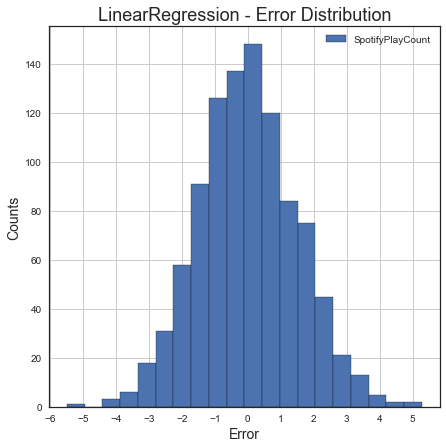

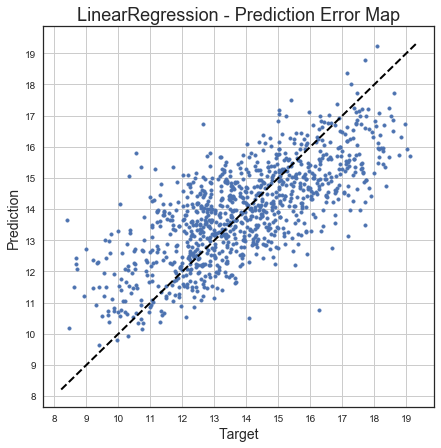

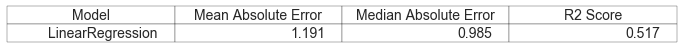

In [108]:
evaluation(lr, feature, target)

In [109]:
'''
for i in range(0, 986):
#for i in range(0, 2):
    print(i)
    song5   = df_music5.iloc[i, :]      # song in dataset-12-5
    artist5 = song5.Artist
    title5  = song5.Title
    genre5  = song5.Genre
    
    for j in range(0, 986):
        song4   = df_music4.iloc[j, :]  # song in dataset-12-4
        artist4 = song4.Artist
        title4  = song4.Title
        genre4  = song4.Genre
        
        if artist5 == artist4 and title5 == title4:
            song4.Genre = genre5
            df_music4.iloc[j,:] = song4
            continue
'''

'\nfor i in range(0, 986):\n#for i in range(0, 2):\n    print(i)\n    song5   = df_music5.iloc[i, :]      # song in dataset-12-5\n    artist5 = song5.Artist\n    title5  = song5.Title\n    genre5  = song5.Genre\n    \n    for j in range(0, 986):\n        song4   = df_music4.iloc[j, :]  # song in dataset-12-4\n        artist4 = song4.Artist\n        title4  = song4.Title\n        genre4  = song4.Genre\n        \n        if artist5 == artist4 and title5 == title4:\n            song4.Genre = genre5\n            df_music4.iloc[j,:] = song4\n            continue\n'

# Test the Genres

In [117]:
dummy_genre = pd.get_dummies(df_music5.Genre)

In [118]:
dummy_genre.head()

,beat,country,easyListening,folkORfunk,instrumental,jazz,pop,popRock,r&b,rock,rockabilly,sunshinePop,traditionalPop
0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0


In [119]:
df_musicf = df_music5.join(dummy_genre, how='outer')

In [122]:
df_musicf.to_csv('../music_data/dateset-12-5-test.csv', index=False)

In [15]:
df_musicf = pd.read_csv('../music_data/dataset-12-6.csv')

In [16]:
do_log(df_musicf,feature_list=['RankPowerlaw', 'SpotifyPlayCount', 'WikiWordCount', 'Followers'])
z_score_norm(df_musicf, feature_list=['RankPowerlaw', 'Year', 'WikiWordCount', 'Followers', 'Popularity'])

In [17]:
df_musicf.columns

Index(['Rank', 'RankPowerlaw', 'Artist', 'Title', 'Year', 'SpotifyPlayCount',
       'WikiWordCount', 'Followers', 'Popularity', 'Grammy', 'Genre', 'beat',
       'country', 'easyListening', 'folkORfunk', 'instrumental', 'jazz', 'pop',
       'popRock', 'r&b', 'rock', 'rockabilly', 'sunshinePop',
       'traditionalPop'],
      dtype='object')

This is the plots/reports of LinearRegression


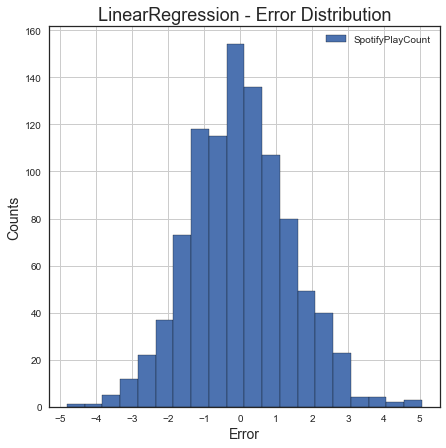

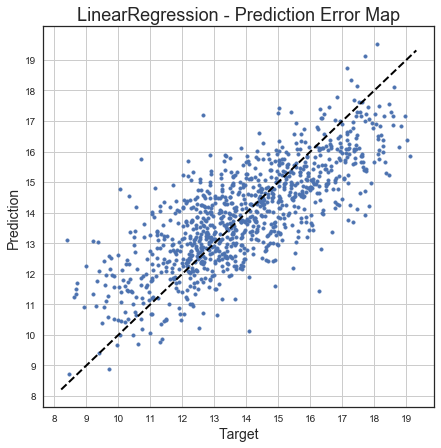

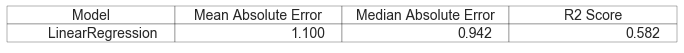

In [18]:
feature_list1 = ['RankPowerlaw', 'Year', 'WikiWordCount', 'Followers', 'Popularity', 'beat', 'country', 
                'folkORfunk', 'instrumental', 'jazz', 'pop', 'popRock', 'r&b', 'rock', 'rockabilly', 'sunshinePop', 'traditionalPop']

target_list = ['SpotifyPlayCount']

feature1 = df_musicf.loc[:,feature_list1]
target  = df_musicf.loc[:,target_list]

lr = linear_model.LinearRegression()
evaluation(lr, feature1, target)

In [131]:
lr = linear_model.LinearRegression()

This is the plots/reports of LinearRegression


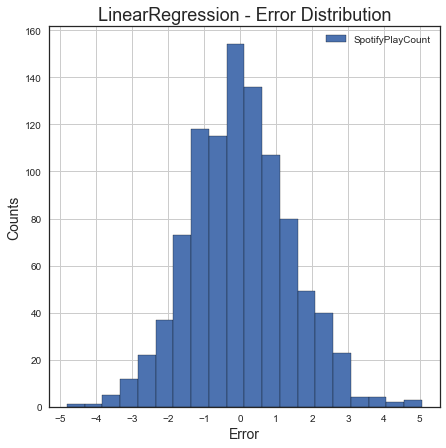

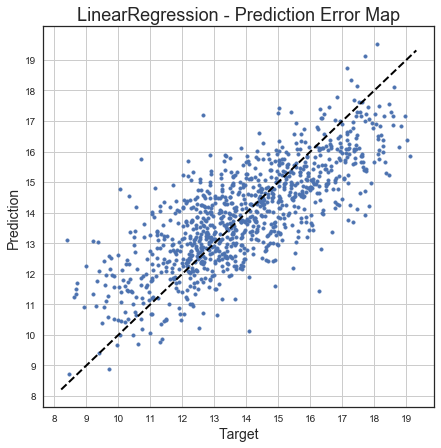

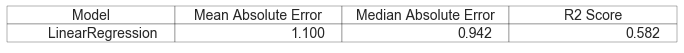

In [132]:
evaluation(lr, feature1, target)

This is the plots/reports of LinearRegression


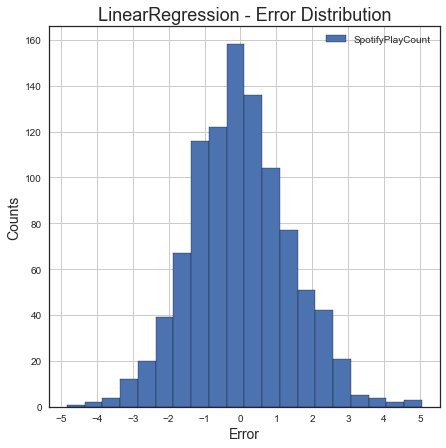

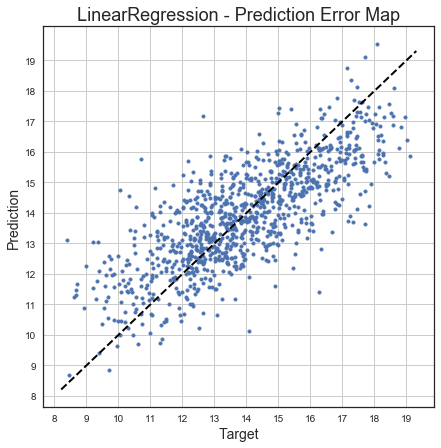

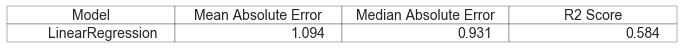

In [20]:
feature_list2 = ['RankPowerlaw', 'Year', 'WikiWordCount', 'Followers', 'Popularity', 
                 'beat', 'easyListening', 'instrumental', 'pop', 'popRock', 'r&b', 'rock', 'rockabilly', 'traditionalPop']

target_list = ['SpotifyPlayCount']

feature1 = df_musicf.loc[:,feature_list2]
target  = df_musicf.loc[:,target_list]

lr = linear_model.LinearRegression()
evaluation(lr, feature1, target)

This is the plots/reports of LinearRegression


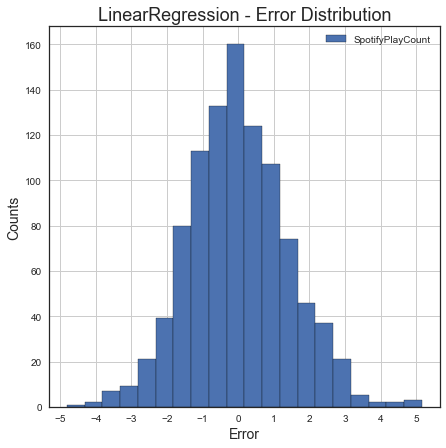

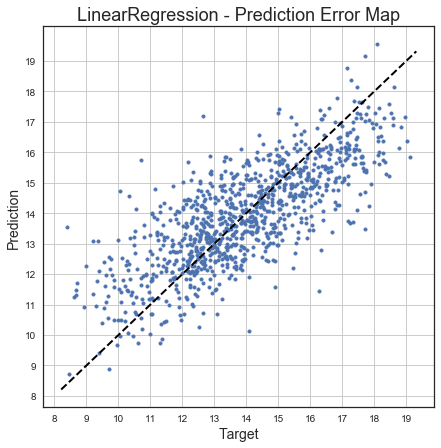

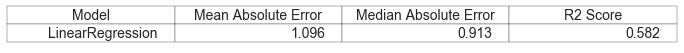

In [148]:
feature_list3 = ['RankPowerlaw', 'Year', 'WikiWordCount', 'Followers', 'Popularity', 
                 'beat', 'easyListening', 'instrumental', 'pop', 'r&b', 'rock', 'rockabilly', 'traditionalPop']

target_list = ['SpotifyPlayCount']

feature1 = df_musicf.loc[:,feature_list3]
target  = df_musicf.loc[:,target_list]

lr = linear_model.LinearRegression()
evaluation(lr, feature1, target)

This is the plots/reports of Ridge


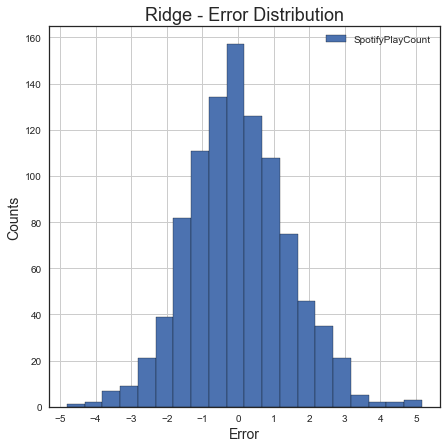

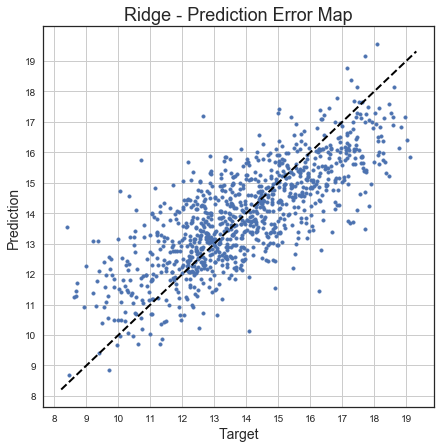

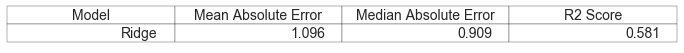

In [34]:
feature_list3 = ['RankPowerlaw', 'Year', 'WikiWordCount', 'Followers', 'Popularity', 
                 'beat', 'easyListening', 'instrumental', 'pop', 'r&b', 'rock', 'rockabilly', 'traditionalPop']

target_list = ['SpotifyPlayCount']

feature3 = df_musicf.loc[:,feature_list3]
target  = df_musicf.loc[:,target_list]

reg = linear_model.Ridge (alpha = -0.5)
evaluation(reg, feature3, target)

# Add Grammy Awards

In [160]:
df_grammy = pd.read_csv('../music_data/grammy_new.csv')

In [59]:
df_musicf2 = pd.read_csv('../music_data/dataset-12-6.csv')

In [60]:
df_musicf2.describe()

,Rank,RankPowerlaw,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,Grammy,beat,country,...,folkORfunk,instrumental,jazz,pop,popRock,r&b,rock,rockabilly,sunshinePop,traditionalPop
count,986.000000,986.000000,986.000000,9.860000e+02,986.000000,9.860000e+02,986.000000,986.000000,986.000000,986.000000,...,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,50.511156,11.711017,1964.517241,8.010619e+06,3362.480730,3.074659e+05,50.812373,0.094320,0.021298,0.053753,...,0.040568,0.027383,0.023327,0.221095,0.048682,0.254564,0.210953,0.017241,0.017241,0.033469
std,28.966082,12.782491,2.878629,2.004174e+07,3958.367503,8.633601e+05,19.009490,0.415717,0.144450,0.225643,...,0.197387,0.163281,0.151015,0.415195,0.215311,0.435837,0.408192,0.130236,0.130236,0.179948
min,1.000000,4.786301,1960.000000,4.348000e+03,108.000000,1.900000e+01,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,5.749304,1962.000000,2.516032e+05,951.000000,4.240000e+03,37.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,7.562751,1965.000000,9.649830e+05,1952.000000,2.805400e+04,52.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.750000,11.949771,1967.000000,5.077456e+06,4169.000000,1.213138e+05,65.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,100.000000,1969.000000,2.010574e+08,19546.000000,5.042014e+06,89.000000,7.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
for i in range(0, 80):
    songG   = df_grammy.loc[i, :]
    artistG = songG.Artist
    titleG  = songG.Title
    grammy  = songG.awardscore
    print(i)
    
    for j in range(0, 986):
        song   = df_musicf2.loc[j, :]
        artist = song.Artist
        title  = song.Title
        if artistG == artist and titleG == title:
            song.Grammy = grammy
            df_musicf2.loc[j, :] = song
            print(artist, ',', title, ',', grammy)

In [176]:
df_musicf2.to_csv('../music_data/dataset-12-6.csv', index=False)

In [61]:
df_musicf2 = pd.read_csv('../music_data/dataset-12-6.csv')

In [62]:
df_musicf2.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,Grammy,...,folkORfunk,instrumental,jazz,pop,popRock,r&b,rock,rockabilly,sunshinePop,traditionalPop
0,1,100.000000,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,1180,9877,52,2,...,0,0,0,0,0,0,0,0,0,0
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,4240,59717,59,0,...,0,0,0,0,0,0,0,0,0,0
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,4114,120725,63,0,...,0,0,0,1,0,0,0,0,0,0
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716,4114,120725,63,0,...,0,0,0,1,0,0,0,0,0,0
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,4114,120725,63,0,...,0,0,0,1,0,0,0,0,0,0


In [63]:
do_log(df_musicf2,feature_list=['RankPowerlaw', 'SpotifyPlayCount', 'WikiWordCount', 'Followers'])
z_score_norm(df_musicf2, feature_list=['RankPowerlaw', 'Year', 'WikiWordCount', 'Followers', 'Popularity'])

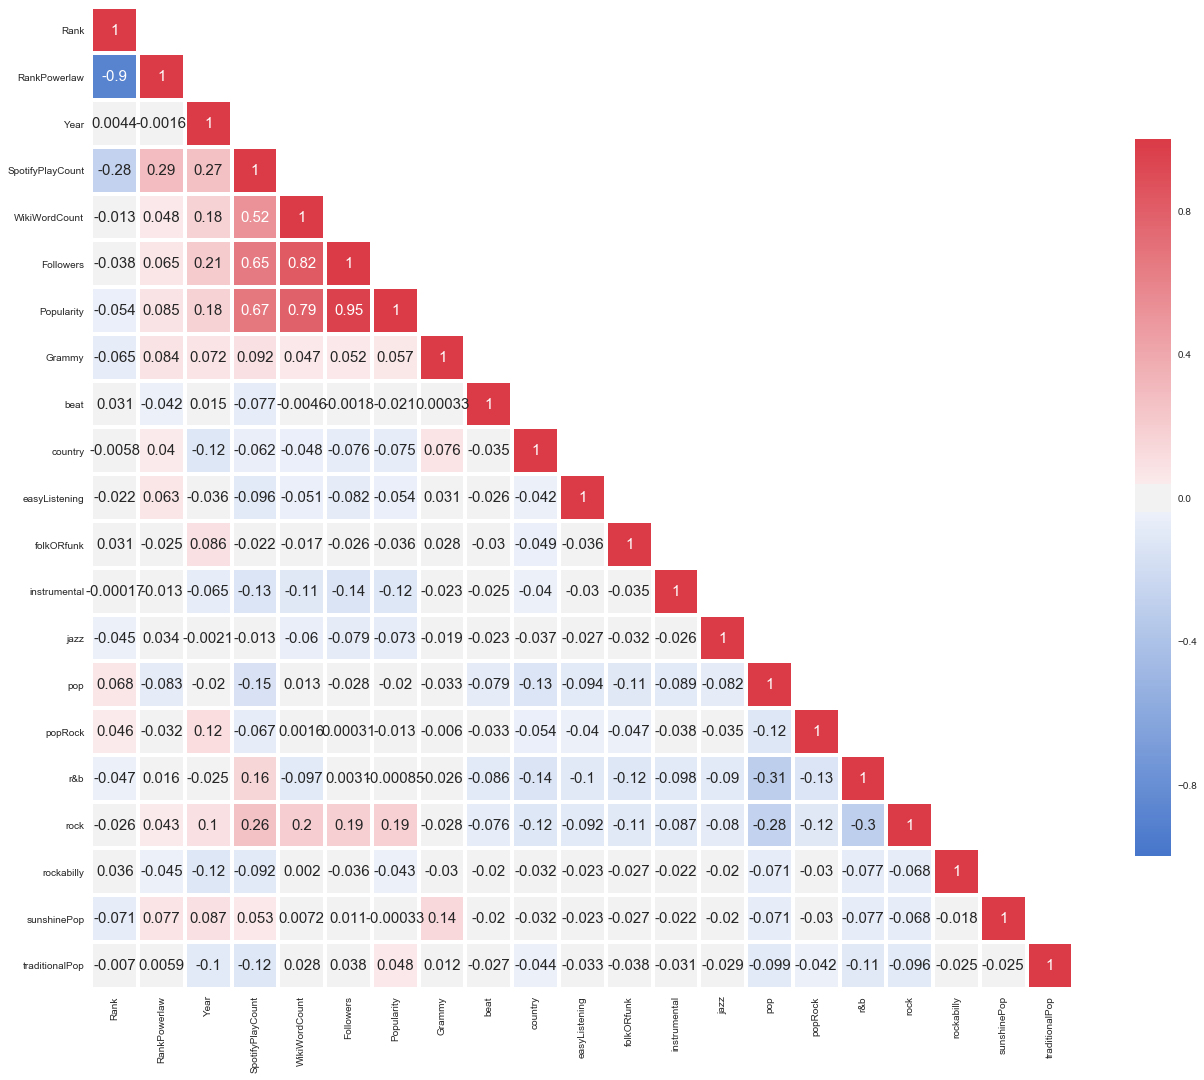

In [56]:
correlation(df_musicf2)

This is the plots/reports of LinearRegression


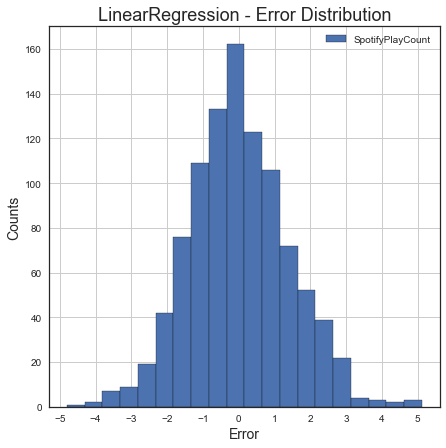

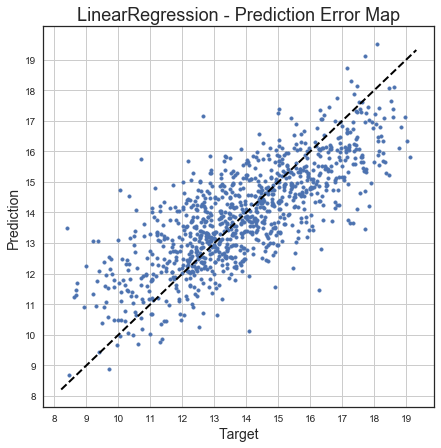

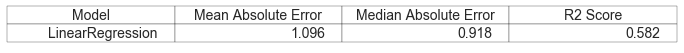

In [65]:
feature_list4 = ['RankPowerlaw', 'Year', 'WikiWordCount', 'Followers', 'Popularity', 'Grammy',
                 'beat', 'easyListening', 'instrumental', 'pop', 'r&b', 'rock', 'rockabilly', 'traditionalPop']

target_list = ['SpotifyPlayCount']

feature1 = df_musicf2.loc[:,feature_list4]
target  = df_musicf2.loc[:,target_list]

lr = linear_model.LinearRegression()
evaluation(lr, feature1, target)

In [189]:
df_musicf2.describe()

,Rank,RankPowerlaw,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,Grammy,beat,country,...,folkORfunk,instrumental,jazz,pop,popRock,r&b,rock,rockabilly,sunshinePop,traditionalPop
count,986.000000,9.860000e+02,9.860000e+02,986.000000,9.860000e+02,9.860000e+02,9.860000e+02,9.860000e+02,986.000000,986.000000,...,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,50.511156,-8.098323e-15,3.599149e-14,13.900855,3.128554e-15,-5.742533e-17,8.312598e-17,-3.467476e-16,0.021298,0.053753,...,0.040568,0.027383,0.023327,0.221095,0.048682,0.254564,0.210953,0.017241,0.017241,0.033469
std,28.966082,1.000000e+00,1.000000e+00,2.160914,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.144450,0.225643,...,0.197387,0.163281,0.151015,0.415195,0.215311,0.435837,0.408192,0.130236,0.130236,0.179948
min,1.000000,-1.047929e+00,-1.569234e+00,8.377471,-2.760823e+00,-2.736043e+00,-2.462579e+00,-2.268864e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,-7.473696e-01,-8.744584e-01,12.435607,-6.885425e-01,-6.561796e-01,-7.266041e-01,-2.268864e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,-2.978544e-01,1.677044e-01,13.779826,-3.528243e-03,7.054642e-02,6.247547e-02,-2.268864e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.750000,4.522199e-01,8.624796e-01,15.440299,7.193292e-01,6.336932e-01,7.463444e-01,-2.268864e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,3.935457e+00,1.557255e+00,19.119101,2.191194e+00,2.067164e+00,2.008872e+00,1.661150e+01,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Counter Culture?

In [228]:
pred = cross_val_predict(lr, X=feature, y=target, cv=10)  # default is 10-fold
best = target - pred
best.insert(0, 'Prediction', pred)
best.rename(columns={'SpotifyPlayCount':'error'}, inplace=True)
best.describe()

,Prediction,error
count,986.000000,986.000000
mean,13.910397,-0.009543
std,1.679111,1.397033
min,8.702937,-5.057186
25%,12.732007,-0.927614
50%,13.908786,0.055667
75%,15.072254,0.968040
max,19.528638,4.820294


In [229]:
#playcount_genre = df_music7.join(dummy_genre, how='outer')
df_musicerror = df_musicf2.join(best, how='outer')

In [231]:
df_musicerror.to_csv('../music_data/dataset-12-6-error.csv', index=False)

In [220]:
best_index = best.nlargest(20, columns='SpotifyPlayCount').index
best.nlargest(20, columns='SpotifyPlayCount')

,Target,Prediction,SpotifyPlayCount
125,16.255563,11.435270,4.820294
513,14.080151,10.123963,3.956187
275,17.717049,13.921407,3.795641
841,17.322973,13.689439,3.633534
433,17.845313,14.230146,3.615167
386,16.316187,12.809776,3.506411
591,17.164588,13.747525,3.417063
648,17.443378,14.131263,3.312115
180,16.674597,13.378932,3.295665
756,14.900998,11.607949,3.293049


In [222]:
df_musicf2.iloc[best_index, :]

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity,Grammy,...,folkORfunk,instrumental,jazz,pop,popRock,r&b,rock,rockabilly,sunshinePop,traditionalPop
125,51,-0.319283,Billy Bland,Let The Little Girl Dance,-1.569234,16.255563,-1.905766,-1.811980,-1.936526,0,...,0,0,0,0,0,1,0,0,0,0
513,97,-1.014968,Billy J. Kramer and The Dakotas,Bad to Me,-0.179683,14.080151,-0.370453,-1.524024,-2.199553,0,...,0,0,0,1,0,0,0,0,0,0
275,95,-0.992423,Dave Brubeck,Take Five,-1.221846,17.717049,0.585608,0.267111,0.535923,0,...,0,0,1,0,0,0,0,0,0,0
841,48,-0.253680,Scott Mckenzie,San Francisco (Be Sure to Wear Flowers in Your...,0.862480,17.322973,-0.919824,-0.130847,0.272897,0,...,0,0,0,1,0,0,0,0,0,0
433,45,-0.183841,The Ronettes,Be My Baby,-0.527071,17.845313,0.797808,0.356727,0.956766,0,...,0,0,0,1,0,0,0,0,0,0
386,98,-1.026067,The Chiffons,One Fine Day,-0.527071,16.316187,-0.647374,-0.101922,0.062475,0,...,0,0,0,1,0,0,0,0,0,0
591,99,-1.037053,The Kingsmen,Louie Louie,-0.179683,17.164588,0.281919,-0.297620,0.009870,0,...,0,0,0,0,0,0,1,0,0,0
648,64,-0.564989,Tom Jones,It's Not Unusual,0.167704,17.443378,0.805353,0.813835,0.746344,0,...,0,0,0,1,0,0,0,0,0,0
180,98,-1.026067,Maurice Williams and the Zodiacs,Stay,-1.569234,16.674597,-0.865233,-0.504127,-0.095340,2,...,0,0,0,0,0,1,0,0,0,0
756,99,-1.037053,B. J. Thomas,Hooked On A Feeling,1.557255,14.900998,-0.572676,0.103453,-1.620894,0,...,0,0,0,1,0,0,0,0,0,0


In [237]:
df_musice = pd.read_csv('../music_data/dataset-12-6-error.csv')

In [239]:
df_musice.nlargest(986, columns='Error').to_csv('../music_data/dataset-12-6-error-order.csv', index=False)